In [1]:
%pip install torch torchvision opencv-python matplotlib seaborn tqdm scikit-learn

You should consider upgrading via the 'c:\Users\nelly\Desktop\BEA_Project_2\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [3]:
import os
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, folder, label, transform=None, seq_len=10):
        self.transform = transform
        self.seq_len = seq_len
        self.label = label
        self.samples = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".mp4")]

    def __len__(self):
        return len(self.samples)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (64, 64))
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        if len(frames) < self.seq_len:
            return None
        idxs = np.linspace(0, len(frames) - 1, self.seq_len).astype(int)
        return torch.stack([frames[i] for i in idxs])

    def __getitem__(self, idx):
        path = self.samples[idx]
        frames = self.read_video(path)
        while frames is None:
            idx = (idx + 1) % len(self.samples)
            path = self.samples[idx]
            frames = self.read_video(path)
        return frames, torch.tensor(self.label, dtype=torch.long)


In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

base = "tapping_hands"

train_data = [
    VideoDataset(os.path.join(base, "tapping/training"), 1, transform),
    VideoDataset(os.path.join(base, "non-tapping/training"), 0, transform)
]

test_data = [
    VideoDataset(os.path.join(base, "tapping/testing"), 1, transform),
    VideoDataset(os.path.join(base, "non-tapping/testing"), 0, transform)
]

train_dataset = ConcatDataset(train_data)
test_dataset = ConcatDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")


Train: 260 | Test: 64


In [5]:
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 1/20 | Loss: 32.0836


100%|██████████| 65/65 [01:17<00:00,  1.18s/it]


Epoch 2/20 | Loss: 17.2469


100%|██████████| 65/65 [01:23<00:00,  1.28s/it]


Epoch 3/20 | Loss: 13.2265


100%|██████████| 65/65 [01:10<00:00,  1.09s/it]


Epoch 4/20 | Loss: 11.9543


100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 5/20 | Loss: 7.8394


100%|██████████| 65/65 [01:04<00:00,  1.01it/s]


Epoch 6/20 | Loss: 5.3920


100%|██████████| 65/65 [01:04<00:00,  1.01it/s]


Epoch 7/20 | Loss: 7.4511


100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 8/20 | Loss: 9.1600


100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 9/20 | Loss: 9.1593


100%|██████████| 65/65 [01:20<00:00,  1.25s/it]


Epoch 10/20 | Loss: 7.0499


100%|██████████| 65/65 [01:18<00:00,  1.21s/it]


Epoch 11/20 | Loss: 5.6208


100%|██████████| 65/65 [01:12<00:00,  1.12s/it]


Epoch 12/20 | Loss: 6.3813


100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 13/20 | Loss: 3.9997


100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 14/20 | Loss: 5.5173


100%|██████████| 65/65 [01:15<00:00,  1.16s/it]


Epoch 15/20 | Loss: 5.1224


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 16/20 | Loss: 6.7755


100%|██████████| 65/65 [01:09<00:00,  1.07s/it]


Epoch 17/20 | Loss: 8.7397


100%|██████████| 65/65 [01:10<00:00,  1.09s/it]


Epoch 18/20 | Loss: 3.4721


100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 19/20 | Loss: 2.3585


100%|██████████| 65/65 [01:05<00:00,  1.00s/it]

Epoch 20/20 | Loss: 5.2937



Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

 Non-Tapping       1.00      1.00      1.00        32
     Tapping       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



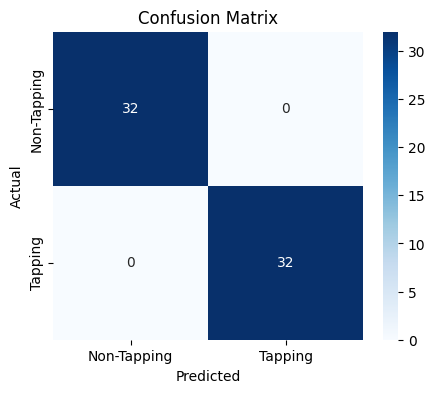

In [23]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {acc:.2f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Tapping", "Tapping"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Tapping", "Tapping"], yticklabels=["Non-Tapping", "Tapping"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [24]:
torch.save(model.state_dict(), "bea_cnn_lstm_v2.pth")
print("Model saved as bea_cnn_lstm_v2.pth")

Model saved as bea_cnn_lstm_v2.pth


In [11]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\nelly\Desktop\BEA_Project_2\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time
import os
import pygame
import mediapipe as mp

# --- Model Definition ---
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

# --- Setup ---
SEQ_FRAMES = 10
IMG_SIZE = 64
AUDIO_FILE = "beep.wav"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CNNLSTM().to(device)
model.load_state_dict(torch.load("bea_cnn_lstm_v2.pth", map_location=device))
model.eval()

# Init audio
pygame.mixer.init()
if os.path.exists(AUDIO_FILE):
    beep = pygame.mixer.Sound(AUDIO_FILE)
else:
    beep = None

# Init mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hand_tracker = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Frame transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# --- GUI App ---
class TapCounterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Tapping Counter (Per Minute Display)")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Taps this minute: 0", font=("Arial", 18))
        self.count_label.pack(pady=5)

        self.total_label = tk.Label(root, text="Total Minutes Logged: 0", font=("Arial", 14))
        self.total_label.pack(pady=5)

        self.cap = cv2.VideoCapture(0)
        self.prev_gray = None
        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.total_minutes = 0
        self.prev_pred = 0
        self.last_tap_time = time.time()
        self.min_interval = 0.1

        self.start_time = time.time()
        self.last_logged_minute = 0

        self.update_frame()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            self.root.after(10, self.update_frame)
            return

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_img = cv2.resize(rgb, (640, 480))
        model_input_frame = display_img.copy()

        # Draw hand skeletons
        results = hand_tracker.process(display_img)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(display_img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        img = Image.fromarray(display_img)
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.configure(image=imgtk)

        gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
        if self.prev_gray is None:
            self.prev_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
            self.root.after(30, self.update_frame)
            return

        curr_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        diff = cv2.absdiff(self.prev_gray, curr_gray)
        self.prev_gray = curr_gray

        diff = np.expand_dims(diff, axis=-1)
        diff = np.repeat(diff, 3, axis=-1)
        diff = transform(diff)
        self.frame_queue.append(diff)

        if len(self.frame_queue) == SEQ_FRAMES:
            sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(sequence)
                probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                pred = np.argmax(probs)

            current_time = time.time()
            if (
                self.prev_pred == 0 and pred == 1 and
                (current_time - self.last_tap_time > self.min_interval)
            ):
                self.tap_count += 1
                self.last_tap_time = current_time
                self.count_label.config(text=f"Taps this minute: {self.tap_count}")
                if beep: beep.play()

            self.prev_pred = pred

        elapsed_minutes = int((time.time() - self.start_time) // 60)
        if elapsed_minutes > self.last_logged_minute:
            self.last_logged_minute = elapsed_minutes
            self.total_minutes += 1
            self.count_label.config(text=f"Taps this minute: 0")
            self.total_label.config(text=f"Total Minutes Logged: {self.total_minutes}")
            self.tap_count = 0

        self.root.after(30, self.update_frame)

    def on_close(self):
        self.cap.release()
        self.root.destroy()

# --- Run GUI ---
root = tk.Tk()
app = TapCounterApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_close)
root.mainloop()


pygame 2.6.1 (SDL 2.28.4, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\nelly\Desktop\BEA_Project_2\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nelly\Desktop\BEA_Project_2\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time
import pygame
import os

# --- Model Definition ---
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

# --- Setup ---
SEQ_FRAMES = 10
IMG_SIZE = 64
AUDIO_FILE = "beep.wav"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CNNLSTM().to(device)
model.load_state_dict(torch.load("bea_cnn_lstm_v2.pth", map_location=device))
model.eval()

# Init audio
pygame.mixer.init()
if os.path.exists(AUDIO_FILE):
    beep = pygame.mixer.Sound(AUDIO_FILE)
else:
    beep = None

# Frame transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# --- GUI App ---
class TapVideoApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Tapping Counter (Video Upload)")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Taps Detected: 0", font=("Arial", 18))
        self.count_label.pack(pady=10)

        self.upload_btn = tk.Button(root, text="Upload Video", command=self.process_video)
        self.upload_btn.pack(pady=10)

        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.prev_pred = 0
        self.min_interval = 0.1
        self.last_tap_time = time.time()

    def process_video(self):
        video_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4 *.avi")])
        if not video_path:
            return

        cap = cv2.VideoCapture(video_path)
        self.tap_count = 0
        self.prev_pred = 0
        self.frame_queue.clear()
        self.last_tap_time = time.time()

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display_img = cv2.resize(rgb, (640, 480))
            model_input_frame = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE))
            gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
            diff = cv2.absdiff(gray, gray)  # placeholder for frame diff

            if hasattr(self, 'prev_gray'):
                diff = cv2.absdiff(self.prev_gray, gray)
            self.prev_gray = gray

            diff = np.expand_dims(diff, axis=-1)
            diff = np.repeat(diff, 3, axis=-1)
            diff = transform(diff)
            self.frame_queue.append(diff)

            if len(self.frame_queue) == SEQ_FRAMES:
                sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(sequence)
                    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                    pred = np.argmax(probs)

                current_time = time.time()
                if (
                    self.prev_pred == 0 and pred == 1 and
                    (current_time - self.last_tap_time > self.min_interval)
                ):
                    self.tap_count += 1
                    self.last_tap_time = current_time
                    if beep: beep.play()

                self.prev_pred = pred

            img = Image.fromarray(display_img)
            imgtk = ImageTk.PhotoImage(image=img)
            self.canvas.imgtk = imgtk
            self.canvas.configure(image=imgtk)
            self.count_label.config(text=f"Taps Detected: {self.tap_count}")
            self.root.update()

        cap.release()
        self.count_label.config(text=f"Total Taps: {self.tap_count}")

# --- Run GUI ---
root = tk.Tk()
app = TapVideoApp(root)
root.protocol("WM_DELETE_WINDOW", root.destroy)
root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\nelly\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\nelly\AppData\Local\Temp\ipykernel_30856\1879935836.py", line 130, in process_video
    imgtk = ImageTk.PhotoImage(image=img)
  File "c:\Users\nelly\Desktop\BEA_Project_2\.venv\lib\site-packages\PIL\ImageTk.py", line 129, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
  File "C:\Users\nelly\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4093, in __init__
    Image.__init__(self, 'photo', name, cnf, master, **kw)
  File "C:\Users\nelly\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4026, in __init__
    master = _get_default_root('create image')
  File "C:\Users\nelly\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 297, in _get_default_root
    raise RuntimeError(f"Too early to {what}: no d